<a href="https://colab.research.google.com/github/prabathreddy04/Grey-Scale-Image-Colorization/blob/main/model1/src/src.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tensorflow.keras.datasets import cifar10
from PIL import Image
import tensorflow as tf               #deep learning library , used for training nerural netwrorks
import numpy as np
from matplotlib import pyplot as plt

# Configuration

batch_size = 64         #number of images processes per each step
img_size = 32           # CIFAR-10 images are 32x32
dataset_split = 1000    # Use only 1000 samples
num_epochs = 100


In [ ]:
# Load CIFAR-10 dataset
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Combine training and test datasets to sample 1000 images
x_data = np.concatenate((x_train, x_test))[:dataset_split]

# Prepare grayscale and RGB images
x = []
y = []

for rgb_image in x_data:
    rgb_image_resized = Image.fromarray(rgb_image).resize((img_size, img_size))
    # Normalize the RGB image array
    rgb_img_array = np.asarray(rgb_image_resized) / 255
    gray_image = rgb_image_resized.convert('L')
    # Normalize the grayscale image array
    gray_img_array = np.asarray(gray_image).reshape((img_size, img_size, 1)) / 255
    # Append both the image arrays
    x.append(gray_img_array)
    y.append(rgb_img_array)

# Convert lists to numpy arrays
x = np.array(x)
y = np.array(y)

# Split data into train and test sets
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, test_size=0.1)

# Construct tf.data.Dataset object
dataset = tf.data.Dataset.from_tensor_slices((train_x, train_y)).batch(batch_size)


170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
def get_generator_model():
    inputs = tf.keras.layers.Input(shape=(img_size, img_size, 1))


  # Purpose: Compresses the data into a higher-dimensional feature space with 128 channels for capturing intricate details.
    conv1 = tf.keras.layers.Conv2D(16, kernel_size=(5, 5), strides=1)(inputs)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1)(conv1)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)
    conv1 = tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1)(conv1)
    conv1 = tf.keras.layers.LeakyReLU()(conv1)

    conv2 = tf.keras.layers.Conv2D(32, kernel_size=(5, 5), strides=1)(conv1)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)(conv2)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)
    conv2 = tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1)(conv2)
    conv2 = tf.keras.layers.LeakyReLU()(conv2)

    conv3 = tf.keras.layers.Conv2D(64, kernel_size=(5, 5), strides=1)(conv2)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)(conv3)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)
    conv3 = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1)(conv3)
    conv3 = tf.keras.layers.LeakyReLU()(conv3)

    bottleneck = tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, activation='tanh', padding='same')(conv3)

    concat_1 = tf.keras.layers.Concatenate()([bottleneck, conv3])
    conv_up_3 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=1, activation='relu')(concat_1)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(128, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_3)
    conv_up_3 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_3)

    concat_2 = tf.keras.layers.Concatenate()([conv_up_3, conv2])
    conv_up_2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=1, activation='relu')(concat_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(64, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_2)
    conv_up_2 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(5, 5), strides=1, activation='relu')(conv_up_2)

    concat_3 = tf.keras.layers.Concatenate()([conv_up_2, conv1])
    conv_up_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=1, activation='relu')(concat_3)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(32, kernel_size=(3, 3), strides=1, activation='relu')(conv_up_1)
    conv_up_1 = tf.keras.layers.Conv2DTranspose(3, kernel_size=(5, 5), strides=1, activation='sigmoid')(conv_up_1)

    model = tf.keras.models.Model(inputs, conv_up_1)
    return model


In [ ]:
def get_discriminator_model():
    layers = [
        # Initial convolution layer
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=1, activation='relu', input_shape=(img_size, img_size, 3), padding='same'),

        # Down-sampling with strides
        tf.keras.layers.Conv2D(32, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),

        # Second convolutional block
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),

        # Third convolutional block
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=1, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), strides=2, activation='relu', padding='same'),

        # Flatten and dense layers
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')  # Output layer for binary classification
    ]
    model = tf.keras.models.Sequential(layers)
    return model


In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy()
mse = tf.keras.losses.MeanSquaredError()

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output, real_y):
    return mse(fake_output, real_y)

generator_optimizer = tf.keras.optimizers.Adam(0.0005)
discriminator_optimizer = tf.keras.optimizers.Adam(0.0005)

generator = get_generator_model()
discriminator = get_discriminator_model()

@tf.function
def train_step(input_x, real_y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(input_x, training=True)
        real_output = discriminator(real_y, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(generated_images, real_y)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))


In [ ]:
# Define the training step
@tf.function      #tells TensorFlow to optimize and compile the function to improve execution speed by
                  # tracing the function to create a static computation graph.
def train_step(input_x, real_y):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        # Generator produces colorized images
        generated_images = generator(input_x, training=True)    #generator creates fake images from the grayscale input.

        # Discriminator evaluates real and generated images
        real_output = discriminator(real_y, training=True)    # discriminator evaluates the real images (real_y) and predicts whether they are real or fake.
        generated_output = discriminator(generated_images, training=True) #evaluates the generated fake images and predicts whether they are real or fake.

        # Calculate generator and discriminator losses
        gen_loss = generator_loss(generated_images, real_y)         #MSE between the generated images and the real images (real_y).
        disc_loss = discriminator_loss(real_output, generated_output)   #using binary cross-entropy based on the true labels of real and fake images.

    # Compute gradients and apply optimizers
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


In [ ]:
# Number of epochs
num_epochs = 100

# Train the model
for epoch in range(num_epochs):
    print(f"Epoch {epoch + 1}/{num_epochs}")
    epoch_gen_loss = 0
    epoch_disc_loss = 0
    batch_count = 0

    for input_x, real_y in dataset:
        gen_loss, disc_loss = train_step(input_x, real_y)
        epoch_gen_loss += gen_loss
        epoch_disc_loss += disc_loss
        batch_count += 1

    # Average losses over the batches
    avg_gen_loss = epoch_gen_loss / batch_count
    avg_disc_loss = epoch_disc_loss / batch_count

    print(f"Generator Loss: {avg_gen_loss.numpy():.4f}, Discriminator Loss: {avg_disc_loss.numpy():.4f}")


Epoch 1/100
Generator Loss: 0.0602, Discriminator Loss: 1.1919
Epoch 2/100
Generator Loss: 0.0429, Discriminator Loss: 0.8532
Epoch 3/100
Generator Loss: 0.0313, Discriminator Loss: 1.0955
Epoch 4/100
Generator Loss: 0.0274, Discriminator Loss: 0.7538
Epoch 5/100
Generator Loss: 0.0251, Discriminator Loss: 0.5447
Epoch 6/100
Generator Loss: 0.0228, Discriminator Loss: 0.3503
Epoch 7/100
Generator Loss: 0.0207, Discriminator Loss: 0.4544
Epoch 8/100
Generator Loss: 0.0196, Discriminator Loss: 1.2188
Epoch 9/100
Generator Loss: 0.0186, Discriminator Loss: 1.2910
Epoch 10/100
Generator Loss: 0.0179, Discriminator Loss: 0.9033
Epoch 11/100
Generator Loss: 0.0168, Discriminator Loss: 0.5946
Epoch 12/100
Generator Loss: 0.0161, Discriminator Loss: 0.4288
Epoch 13/100
Generator Loss: 0.0155, Discriminator Loss: 0.3482
Epoch 14/100
Generator Loss: 0.0153, Discriminator Loss: 0.3772
Epoch 15/100
Generator Loss: 0.0148, Discriminator Loss: 1.4117
Epoch 16/100
Generator Loss: 0.0143, Discriminato

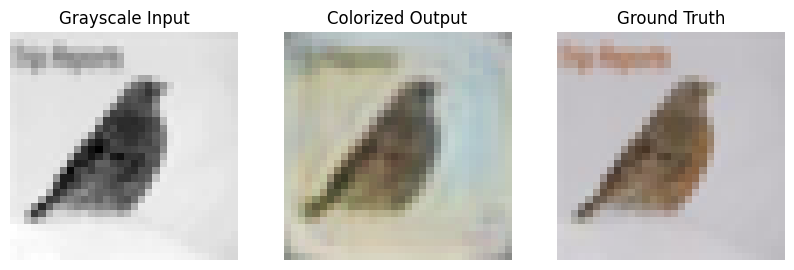

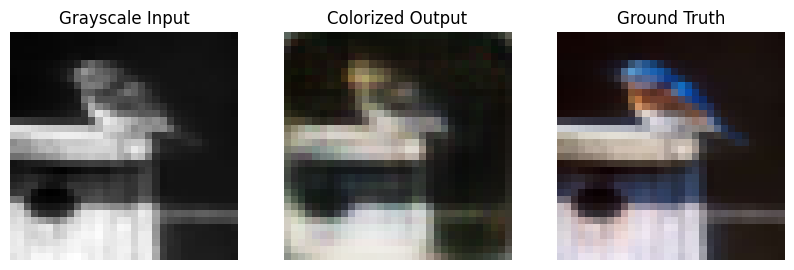

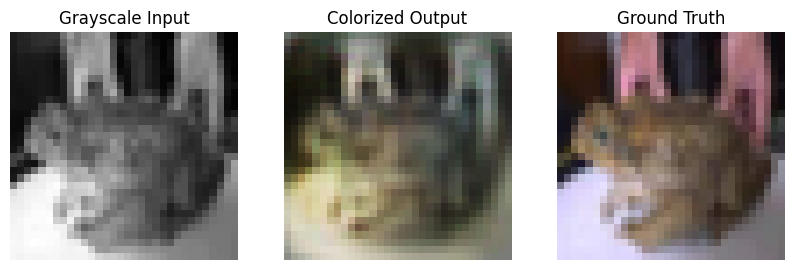

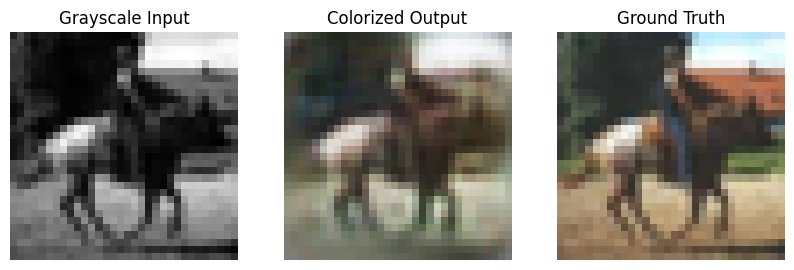

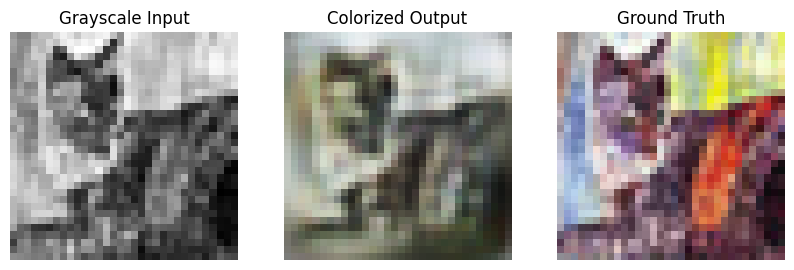

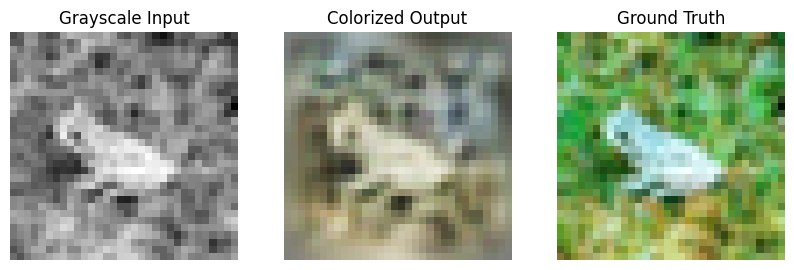

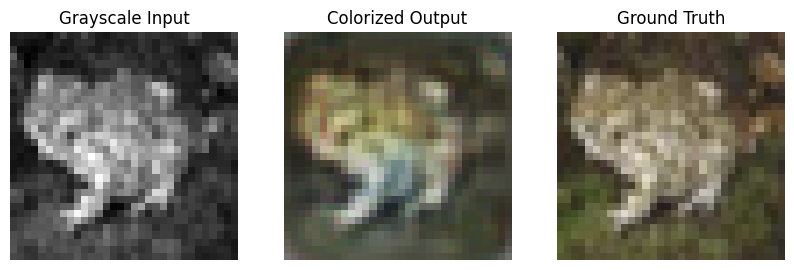

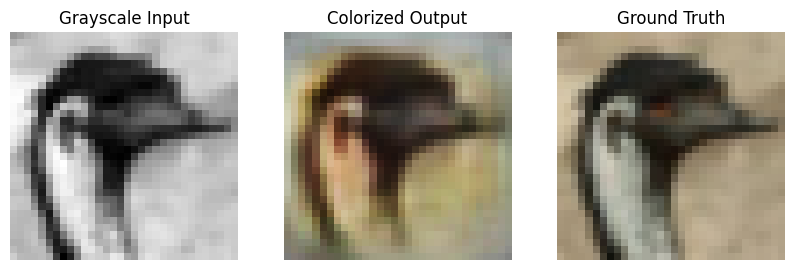

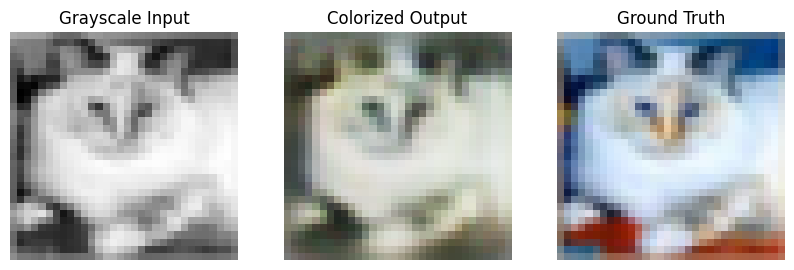

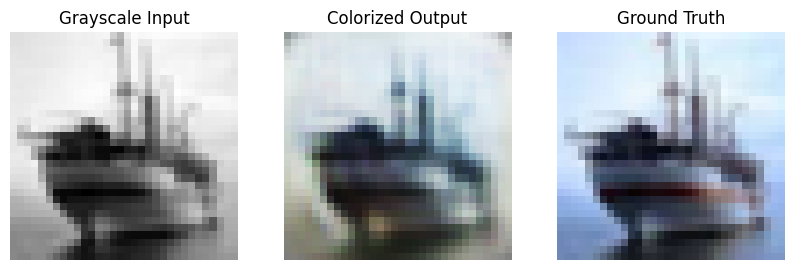

In [ ]:
# Generate predictions on the test dataset
predicted_images = generator(test_x, training=False).numpy()

# Display some sample outputs
for i in range(10):  # Show 5 examples
    plt.figure(figsize=(10, 5))

    # Grayscale input
    plt.subplot(1, 3, 1)
    plt.title("Grayscale Input")
    plt.imshow(test_x[i].reshape(img_size, img_size), cmap='gray')
    plt.axis("off")

    # Colorized output (generated)
    plt.subplot(1, 3, 2)
    plt.title("Colorized Output")
    plt.imshow(predicted_images[i])
    plt.axis("off")

    # Ground truth
    plt.subplot(1, 3, 3)
    plt.title("Ground Truth")
    plt.imshow(test_y[i])
    plt.axis("off")

    plt.show()
